# FIT5202 Data processing for big data

##  Activity: Machine Learning with Spark (Transformer, Estimator and Pipeline API)

This week we are going to learn about machine learning with Apache Spark. **``MLlib``** is Apache Spark's scalable machine learning library. Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:

- ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
- Featurization: feature extraction, transformation, dimensionality reduction, and selection
- Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
- Persistence: saving and load algorithms, models, and Pipelines
- Utilities: linear algebra, statistics, data handling, etc.

This week we are going to learn about transformers, estimators and machine learning pipeline in this tutorial activity.



## Table of Contents

* [Initialize SparkSession](#one)
* [Problem Statement](#problem-statement)
* [Data Loading and Exploration](#data-loading)
* [Transformers and Estimators](#estimators)
    * [StopWordsRemover](#stop-words)
    * [StringIndexer](#string-indexer)        
    * [OneHotEncoder](#ohe)
    * [VectorAssembler](#vector-assembler)
    * [ML Algorithm and Prediction](#ml-algorithm)
* [Pipeline API](#pipeline)
    * [Pipeline API Example](#pipeline-example)
* [Testing with real data](#testing)
* [Lab Tasks](#lab-task-1)
    * [Lab Task 1](#lab-task-1)
    * [Lab Task 2](#lab-task-2)
    * [Lab Task 3](#lab-task-3)    
    * [Lab Task 4](#lab-task-4)

## Initialize Spark Session <a class="anchor" id="one"></a>


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>In the cell block below, 
<ul>
    <li>Create a SparkConfig object with application name set as "Spark ML-Transformer, Estimator and Pipeline"</li>
    <li>specify 2 cores for processing</li>
    <li>Use the configuration object to create a spark session named as <strong>spark</strong>.</li>
    </ul>
    
<p><strong style="color:red">Important:</strong> You cannot proceed to other steps without completing this.</p>
</div>

In [ ]:
# TODO: Import libraries needed from pyspark

# TODO: Create Spark Configuration Object

# TODO: Create SparkSession

## Problem Statement <a class="anchor" id="problem-statement"></a>
<hr/>
Before we jumpstart coding, it is important to understand the problem and its context. The dataset we are using today is the popular <strong>Adult Income Dataset</strong>.[<a href="http://archive.ics.uci.edu/ml/datasets/Adult" target="_BLANK">Source</a>]
The dataset provides different parameters of an individual which might influence his/her income. 


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">Objective:</strong> We want to explore and see if different personal attributes of a person influence his/her income and whether we can use these attributes to predict their income levels.</div>

### Machine Learning Flow
The figure below depicts the flow of the Machine Learning approach we want to take. The <strong>ML Algorithm</strong> we are going to use is <strong>Logistic Regression</strong>. Here, we are not going to get into details of the algorithm. We will look at these in details in coming tutorials.
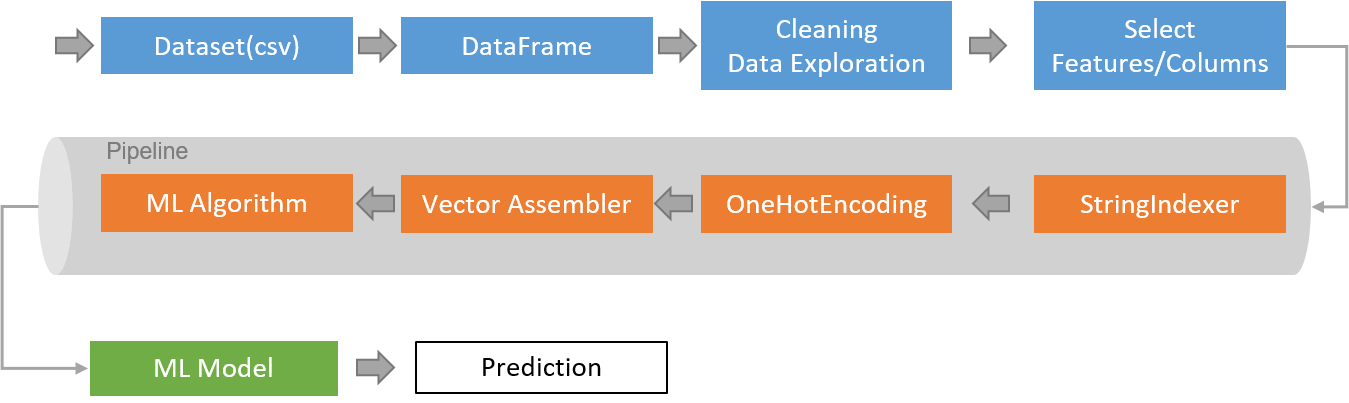

## Data Loading and Pre-processing and Exploration <a class="anchor" name="data-loading"></a>
In this step, we shall load the given <code>adult.csv</code> file, examine the data and some basic data cleaning operations like checking for null values and finally select a set of relevant columns for our analysis.


In [ ]:
#Load the CSV File
df_adult = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('adult.csv')

In [ ]:
#Print the Schema
df_adult.printSchema()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">IMPORTANT:</strong> The <code>income</code> is our <strong>target variable</strong> also called <strong>label</strong> and we are going to use other <strong>independent</strong> variables to predict the target variable.</div>

In [ ]:
#Check the shape of the dataframe
print((df_adult.count(), len(df_adult.columns)))

In [ ]:
#Summary Statistics
df_adult.describe().show(5)

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>
For better readability of dataframes, you can also convert the dataframe to a <strong>Pandas</strong> DataFrame. 
    <span style="color:red">Please note that, we can use this only if we have few rows, since the data is loaded into the driver node.</span>
    Try using <code>df_adult.describe().toPandas().head()</code>
    
<strong style="color:#FF5555">IMPORTANT: </strong>
    To use <code>.toPandas</code>, Pandas has to be installed. If not, please use <code>!pip install pandas</code> to install <strong>Pandas</strong> in Jupyter Notebook.
</div>



<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">Exploratory Analysis: </strong>
Data Exploration and visualization will be covered in the coming tutorials. Here we will focus on the Featurization part.
</div>


For simplicity, we are only considering a set of features from the dataset for our analysis. The columns we want to use are <code>'workclass','education','marital-status','occupation','relationship','race','gender','income'</code>. We are going to create a dataframe with these columns only and use this DataFrame for the rest of our analysis.

In [ ]:
cols=['workclass','education','marital-status','occupation','relationship','race','gender','income']
df = df_adult[cols]
df.show(5)

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong>
    Examine the different unique values the <code>income</code> column has. Display the <code>distinct</code> values of the target variable i.e. the <code>income</code> column. 
</div>


### Checking Missing/Null values
Check for missing data, drop the rows for missing data.<a href="https://www.datasciencemadesimple.com/count-of-missing-nanna-and-null-values-in-pyspark/" target="_BLANK">[Read More]</a>


In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

## Estimators, Transformers and Pipelines <a class="anchor" name="estimators"></a>
<hr/>
Spark's machine learning library has three main abstractions.
<ol>
    <li><strong>Transformer:</strong> Takes dataframe as input and returns a new DataFrame with one or more columns appended to it. Implements a <code>.transform()</code> method.</li>
    <li><strong>Estimator:</strong> Takes dataframe as input and returns a model. Estimator learns from the data. It implements a <code>.fit()</code> method.</li>
    <li><strong>Pipeline:</strong> <strong>Combines</strong> together <code>transformers</code> and <code>estimators</code>. Pipelines implement a <code>.fit</code> method.</li>
</ol>

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
    Spark appends columns to pre-existing <strong>immutable</strong> DataFrames rather than performing operations <strong>in-place</strong>.
</div>

### StopWordsRemover  <a class="anchor" name="stop-words"></a>
<code>StopWordsRemover</code> takes input as a sequence of strings and drops all stop words. Stop Words are the words that should be excluded from the input, because they appear frequently and don't carry much meaning.<a href="https://spark.apache.org/docs/latest/ml-features.html#stopwordsremover" target="_BLANK">[Ref]</a>

In [ ]:
from pyspark.ml.feature import StopWordsRemover

sentenceData = spark.createDataFrame([
    (0, ["I", "saw", "the", "red", "balloon"]),
    (1, ["Mary", "had", "a", "little", "lamb"])
], ["id", "raw"])

remover = StopWordsRemover(inputCol="raw", outputCol="filtered")
remover.transform(sentenceData).show(truncate=False)

### StringIndexer  <a class="anchor" name="string-indexer"></a>
<code>StringIndexer</code> encodes string columns as indices. It assigns a unique value to each category. We need to define the input column/columns name and the output column/columns name in which we want the results.<a href="https://spark.apache.org/docs/latest/ml-features.html#stringindexer" target="_BLANK">[Read More]</a>

In [ ]:
from pyspark.ml.feature import StringIndexer

df_ref = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")],
    ["id", "category"])

indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
indexed_transformer = indexer.fit(df_ref)
indexed = indexed_transformer.transform(df_ref)
indexed.show()

##### Understanding Python List Comprehensions
The examples below use List Comprehensions in Python. You may frequently see this being used. You can read more about it <a href="https://www.programiz.com/python-programming/list-comprehension" target="_BLANK">here</a>.

In [ ]:
# Getting column names from the dataframe 
inputCols=[x for x in df.columns]
print(inputCols)

# Note that we have used Python List Comprehension in the above example
#This is equivalent to doing 
inputCols=[]
for x in df.columns:
    inputCols.append(x)
print(inputCols)

<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong> Use <code>StringIndexer</code> to encode all the columns from the DataFrame <code>df</code> we created in the previous step. <em>Since all the columns we have are categorical in nature, we want to use <code>StringIndexer</code> to transform them into numerical values.</em>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
    You can pass multiple columns as input and output in <code>StringIndexer</code> using <code>StringIndexer(inputCols=["col1","col2"], outputCols=["col1Index","col2Index"])</code>
</div>
</div>

In [ ]:
#Define the input columns
inputCols=[x for x in df.columns]
#Define the output columns 
outputCols=[f'{x}_index' for x in df.columns]
# TODO: Initialize StringIndexer (use inputCols and outputCols)
indexer = 

#TODO call the fit and transform() method to get the encoded results 
df_indexed = 

#TODO Display the output, only the output columns


### One Hot Encoder (OHE) <a class="anchor" name="ohe"></a>
One hot encoding is representation of categorical variables as binary vectors. It works in 2 steps:
1. The categorical variables are mapped as integer values
2. Each integer value is represented as binary vector

<a href="https://spark.apache.org/docs/latest/ml-features.html#onehotencoder" target="_BLANK">[Spark References] </a>
<a href="https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python" target="_BLANK"> [Read More]</a>

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <strong style="color:#006DAE">NOTE: </strong><code>OneHotEncoder</code> in Spark does not directly encode the categorical variable. We have converted the categorical variable to numerical using <code>StringIndexer</code> in the above step. Now we can implement the <code>OHE</code> to the <em>numerical columns</em> obtained from the step above.
    </div>

In [ ]:
#Example of OHE from Spark Documentation
from pyspark.ml.feature import OneHotEncoder

df_ref = spark.createDataFrame([
    (0.0, 1.0),
    (1.0, 0.0),
    (2.0, 1.0),
    (0.0, 2.0),
    (0.0, 1.0),
    (2.0, 0.0)
], ["categoryIndex1", "categoryIndex2"])

encoder = OneHotEncoder(inputCols=["categoryIndex1", "categoryIndex2"],
                        outputCols=["categoryVec1", "categoryVec2"])
model = encoder.fit(df_ref)
encoded = model.transform(df_ref)
encoded.show()

<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">3. Lab Task: </strong>
    Apply <code>OneHotEncoder</code> transformation to all numerical columns in the dataframe. We shouldn't be including the <strong>target</strong> column i.e. <code>income</code> anymore here. We just want to include the features.
</div><br/>

In [ ]:
#WRITE THE CODE WHERE NECESSARY
#the outputcols of previous step act as input cols for this step
inputCols_OHE = #all output columns from StringIndexer exept the Income
outputCols_OHE = [f'{x}_vec' for x in inputCols if x!='income']

#Define OneHotEncoder with the appropriate columns
encoder = 
# Call fit and transform to get the encoded results
df_encoded = 
#Display the output columns


#### Rename the target column to label
<code>label</code> is popularly used as the name for the target variable. In supervised learning, we have a <strong>labelled</strong> dataset which is why the column name <strong>label</strong> makes sense.

In [ ]:
df_encoded=df_encoded.withColumnRenamed('income_index', 'label')

### VectorAssembler <a class="anchor" name="vector-assembler"></a>
Finally, once we have transformed the data, we want to combine all the features into a single feature column to train the machine learning model. <code>VectorAssembler</code> combines the given list of columns to a <em>single vector</em> column.
<a href="https://spark.apache.org/docs/latest/ml-features.html#vectorassembler" target="_BLANK">[Spark Ref]</a>

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

dataset = spark.createDataFrame(
    [(0, 18, 1.0, Vectors.dense([0.0, 10.0, 0.5]), 1.0)],
    ["id", "hour", "mobile", "userFeatures", "clicked"])

assembler = VectorAssembler(
    inputCols=["hour", "mobile", "userFeatures"],
    outputCol="features")

output = assembler.transform(dataset)
print("Assembled columns 'hour', 'mobile', 'userFeatures' to vector column 'features'")
output.select("features", "clicked").show(truncate=False)

<a class="anchor" id="lab-task-4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">4. Lab Task: </strong>
    Referring to the example above, use <code>VectorAssembler</code> to combine the feature columns from <b>Task 2</b> to a single column named <strong>features</strong>.
</div>

In [ ]:
#WRITE THE CODE WHERE NECESSARY
inputCols=#the output columns from Task 3 i.e. OHE

#Define the assembler with appropriate input and output columns
assembler = 
#use the asseembler transform() to get encoded results
df_final = 
#Display the output


### ML Algorithm and Prediction <a class="anchor" name="ml-algorithm"></a>
Here we are using Logistic Regression for the classification. We will explore the details about this algorithm in the next tutorials. Please refer to the <a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression" target="_BLANK">[Spark Docs]</a> for further reference.

In [ ]:
#Splitting the data into testing and training set 90% into training and 10% for testing
train, test = df_final.randomSplit([0.9, 0.1])

In [ ]:
#Implementing the Logistic Regression
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(featuresCol='features',labelCol='label')
model = lr.fit(train)

In [ ]:
#Here we use the model trained with the training data to give predictions for our test data
predicted_data = model.transform(test)
predicted_data.select('features','label','prediction').filter(predicted_data.label==1).show()

In [ ]:
#This gives the accuracy of the model we have built, 
trainingSummary = model.summary
trainingSummary.accuracy

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <strong style="color:#006DAE">NOTE: </strong>What is your interpretation about the accuracy of the model?
    </div>

## Pipeline API <a class="anchor" name="pipeline"></a>
In machine learning, it is common to run a sequence of algorithms to process and learn from data. We have seen in the example above, there is a sequence of steps to be done to prepare the data for training.
Such sequence of steps in Spark can be reqpresented by a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order. We will try to convert the above sequence of transformers and estimators into a Pipeline.
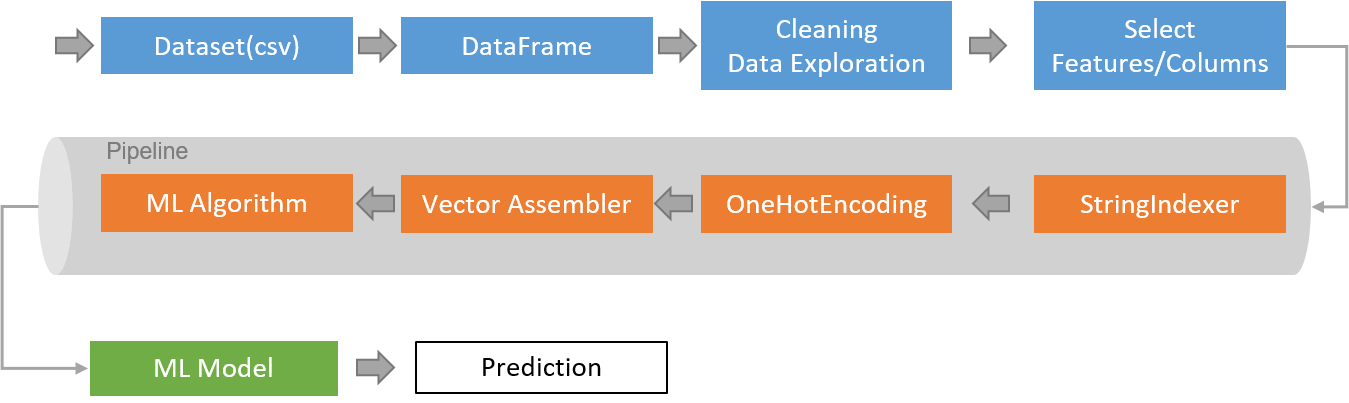
In the figure above, we can the steps <code>StringIndexer, OneHotEncoder, VectorAssembler and MLAlgorithm</code> are plugged into the pipeline.

#### Pipeline API Example <a class="anchor" name="pipeline-example"></a>
An example demonstrating the use of <code>Pipeline</code> taken from <a href="https://spark.apache.org/docs/latest/ml-pipeline.html#example-pipeline" target="_BLANK">[Spark Docs]</a> is given below.
Go through this example to implement your own <code>Pipeline</code> for <strong>Task 5</strong>.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "win million dollar", 1.0),
    (1, "Office meeting", 0.0),
    (2, "Do not miss this opportunity", 1.0),
    (3, "update your password", 1.0),
    (4, "Assignment submission", 0.0)
], ["id", "text", "label"])

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (5, "get bonus of 200 dollars"),
    (6, "change your bank password"),
    (7, "Next meeting is at 5pm"),
    (8, "Late submission"),
    (9, "Daily newsletter")
], ["id", "text"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))


### Congratulations on finishing this activity. See you next week.